In [1]:
import pandas as pd
import re
import string
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import spacy
import random
from nltk.stem import PorterStemmer
import random
import time
import faiss
from nltk.stem import SnowballStemmer
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.float_format = '{:,.4f}'.format
tqdm.pandas()

nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

c:\Users\annap\miniconda3\envs\ri-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\annap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\annap\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\annap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
SnowballStemmer.languages

('arabic',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'hungarian',
 'italian',
 'norwegian',
 'porter',
 'portuguese',
 'romanian',
 'russian',
 'spanish',
 'swedish')

# Read  Files

In [3]:
fn_files = ['cf74', 'cf75', 'cf76', 'cf77', 'cf78', 'cf79']
fn_queries = 'cfquery'

## Document

In [152]:
def extract_informations(filename):
    data = {}
    id_actual = None
    information = ""

    try:
        with open(filename, "r", encoding='ansi') as file:
            for line in file:
                if line.startswith("RN"): # É o ID
                    # Se há uma informação anterior, armazena no dicionário
                    if id_actual and information:
                        data[id_actual] = information
                        information = ""

                    # Obtém o ID a partir da segunda palavra
                    id_actual = line.split()[1]
                elif line.startswith(("TI", "MJ", "MN", "AB", "EX")) and id_actual:
                    information += line[3:].strip()
                    while True:
                        next_line = file.readline()
                        if not next_line or re.match(r'\b[A-Z]{2}\s', next_line):
                            break
                        information += " " + next_line.strip()

            # Adiciona a última informação ao dicionário
            if id_actual and information:
                data[id_actual] = information

    except FileNotFoundError:
        print("File not founded.")

    return data

# Dicionário para armazenar os data
data_complete = {}

# Extrai as informações de cada file
for fn in fn_files:
    path_file = f"../data/{fn}"
    data = extract_informations(path_file)

    data_complete.update(data)

df_data = pd.DataFrame(list(data_complete.items()), columns=['id', 'TEXT']).rename(columns={'id':'id_document'})
df_data = df_data.astype({'id_document': int})
df_data.head()

,id_document,TEXT
0,1,Pseudomonas aeruginosa infection in cystic fib...
1,2,Amylase content of mixed saliva in children.SA...
2,3,A clinical study of the diagnosis of cystic fi...
3,4,A methodological study of the diagnosis of cys...
4,5,Proteolytic activity in duodenal juice in infa...


## Query

In [153]:
def read_file_query(file_path):
 
    data = {'QN': [], 'QU': [], 'NR': [], 'RD': []}

    qn_id = None
    qu_texto = None
    nr_numero = None
    rd_lista = []

    with open(file_path, 'r') as arquivo:
        for linha in arquivo:
            if linha.startswith('RD'):
                rd_lista = [int(x) for x in re.findall(r'\d+', linha)]
                while True:
                    try:
                        proxima_linha = next(arquivo)
                        if proxima_linha.startswith('QN'):
                            # Salva os dados acumulados até aqui
                            if qn_id is not None:
                                data['QN'].append(qn_id)
                                data['QU'].append(qu_texto)
                                data['NR'].append(nr_numero)
                                data['RD'].append(rd_lista)
                            # Reinicia as variáveis para o próximo 'QN'
                            qn_id = int(re.search(r'\d+', proxima_linha).group())
                            qu_texto = None
                            nr_numero = None
                            rd_lista = []
                            break
                        rd_lista.extend([int(x) for x in re.findall(r'\d+', proxima_linha)])
                    except StopIteration:
                        break
            elif linha.startswith('QN'):
                qn_id = int(re.search(r'\d+', linha).group())
            elif linha.startswith('QU'):
                qu_texto = linha[3:].strip()
            elif linha.startswith('NR'):
                nr_numero = int(re.search(r'\d+', linha).group())

    # Adiciona os últimos dados, se houver
    if qn_id is not None:
        data['QN'].append(qn_id)
        data['QU'].append(qu_texto)
        data['NR'].append(nr_numero)
        data['RD'].append(rd_lista)

    df = pd.DataFrame(data)
    df["RD"] = df["RD"].apply(lambda x: x[::2])
    df["len(RD)"] = df["RD"].apply(lambda x: len(x))
    
    return df

# Lê o arquivo e cria o DataFrame
df_query = read_file_query(f'../data/{fn_queries}')
df_query = df_query.rename(columns={'QN':'id_query'}).astype({'id_query': int})
df_query.head()

,id_query,QU,NR,RD,len(RD)
0,1,What are the effects of calcium on the physica...,34,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ...",34
1,2,Can one distinguish between the effects of muc...,7,"[169, 434, 454, 498, 499, 592, 875]",7
2,3,How are salivary glycoproteins from CF patient...,43,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34...",43
3,4,What is the lipid composition of CF respirator...,9,"[503, 538, 539, 540, 553, 604, 669, 711, 876]",9
4,5,Is CF mucus abnormal?,131,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,...",131


# Text preprocessing

In [154]:
pp_config = { 'convert': 'lower', # lower or upper 
              'reduce': 'lemming', # stemming or lemming  lemming
              'stop_words': True,  # remove if true else ~remove
              'punctuation':True, # remove if true, else ~remove
              'number': True,
             }

def lemmatize_text_spacy(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

def stem_text(text):
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in word_tokenize(text)])

def remove_stopwords_from_text(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def remove_punctuation_nltk(text):
    
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = word_tokenize(text)
    tokens_without_punctuation = [word for word in tokens if word not in string.punctuation]
    
    return ' '.join(tokens_without_punctuation)

def remove_number(text):
    return ' '.join(re.sub(r'\w*\d\w*', '', word) for word in word_tokenize(text))

def preprocess_english_text(text, conf:dict, n_exemple:int):
    
    pp_stats = {}

    if conf['convert'] == 'lower':
        print(f"Before lower ex.: {text[n_exemple].split('.')[0]}")
        text = text.str.lower()
        pp_count_words = list(map(lambda string: len(string.split()), text))
        pp_stats['lower'] = pp_count_words
        print(f"-> After lower ex.:  {text[n_exemple].split('.')[0]}")

    if conf['convert'] == 'upper':
        print(f"Before upper ex.: {text[n_exemple].split('.')[0]}")
        text = text.str.upper()
        pp_count_words = list(map(lambda string: len(string.split()), text))
        pp_stats['upper'] = pp_count_words
        print(f"-> After upper ex.:  {text[n_exemple].split('.')[0]}")

    if conf['reduce'] == 'lemming':
        print(f"Before lemmatizer ex.: {text[n_exemple].split('.')[0]}")
        processed = text.apply(lemmatize_text_spacy)
        pp_count_words = list(map(lambda string: len(string.split()), text))
        pp_stats['reduce'] = pp_count_words
        print(f"-> After lemmatizer ex.: {processed[n_exemple].split('.')[0]}")

    if conf['reduce'] == 'steamming':
        print(f"Before stemming ex.: {text.iloc[n_exemple].split('.')[0]}")
        processed = text.apply(stem_text)
        pp_count_words = processed.apply(lambda x: len(x.split()))
        pp_stats['reduce'] = pp_count_words
        print(f"-> After stemming ex.: {processed.iloc[n_exemple].split('.')[0]}")

    if conf['stop_words'] == True:        
        print(f"Before stopword ex.: {processed[n_exemple].split('.')[0]}")
        processed = processed.apply(remove_stopwords_from_text)
        pp_count_words = processed.apply(lambda x: len(x.split()))
        pp_stats['stop_words'] = pp_count_words
        print(f"-> After stopword ex.: {processed.iloc[n_exemple].split('.')[0]}")

    if conf['punctuation'] == True:
        print(f"Before remove punctuation ex.:  {processed[n_exemple].split('.')[0]}")
        processed = processed.apply(remove_punctuation_nltk)
        pp_count_words = processed.apply(lambda x: len(x.split()))
        pp_stats['punctuation'] = pp_count_words
        print(f"-> After remove ponctuation ex.: {processed.iloc[n_exemple].split('.')[0]}")
    
    if conf['number'] == True:

        print(f"Before remove numbers ex.:  {processed[n_exemple].split('.')[0]}")
        processed = [remove_number(text) for text in processed]
        pp_count_words = [len(text.split()) for text in processed]
        pp_stats['number'] = pp_count_words
        print(f"-> After remove numbers ex.: {processed[n_exemple].split('.')[0]}")

    return processed, pp_stats

In [155]:
print(f"{'-'*50}Data: Document{'-'*50}")
df_data_pp = df_data.copy()
df_data_pp['pp'], pp_count_d= preprocess_english_text(df_data['TEXT'], pp_config, n_exemple=0)

print(f"{'-'*50}Data: Queries{'-'*50}")
df_query_pp = df_query.copy()
df_query_pp['pp'], pp_count_q= preprocess_english_text(df_query['QU'], pp_config, n_exemple=0)

--------------------------------------------------Data: Document--------------------------------------------------
Before lower ex.: Pseudomonas aeruginosa infection in cystic fibrosis
-> After lower ex.:  pseudomonas aeruginosa infection in cystic fibrosis
Before lemmatizer ex.: pseudomonas aeruginosa infection in cystic fibrosis
-> After lemmatizer ex.: pseudomonas aeruginosa infection in cystic fibrosis 
Before stopword ex.: pseudomonas aeruginosa infection in cystic fibrosis 
-> After stopword ex.: pseudomonas aeruginosa infection cystic fibrosis 
Before remove punctuation ex.:  pseudomonas aeruginosa infection cystic fibrosis 
-> After remove ponctuation ex.: pseudomonas aeruginosa infection cystic fibrosis occurrence precipitate antibody pseudomonas aeruginosa relation concentration sixteen serum protein clinical radiographical status lungscystic fibrosis co pseudomonas aeruginosa m pseudomona infection co respiratory tract infection cothe significance pseudomonas aeruginosa infe

In [156]:
def contabilize_stats(data, stats)->pd.DataFrame:

    data['lower_len'] = stats['lower']
    data['reduce_len'] = stats['reduce']
    data['stop_len'] = stats['stop_words']
    data['punc_len'] = stats['punctuation']
    data['num_len'] = stats['number']

    return data

df_data_pp = contabilize_stats(df_data_pp, pp_count_d)
df_query_pp = contabilize_stats(df_query_pp, pp_count_q)

df_data_pp.head()

,id_document,TEXT,pp,lower_len,reduce_len,stop_len,punc_len,num_len
0,1,Pseudomonas aeruginosa infection in cystic fib...,pseudomonas aeruginosa infection cystic fibros...,207,207,155,130,124
1,2,Amylase content of mixed saliva in children.SA...,amylase content mixed saliva childrensaliva en...,152,152,120,103,98
2,3,A clinical study of the diagnosis of cystic fi...,clinical study diagnosis cystic fibrosis instr...,157,157,115,94,90
3,4,A methodological study of the diagnosis of cys...,methodological study diagnosis cystic fibrosis...,203,203,136,111,111
4,5,Proteolytic activity in duodenal juice in infa...,proteolytic activity duodenal juice infant chi...,129,129,124,92,85


## Preprocessing reduced by synonyms

In [157]:
def get_vocabulary(data_text, query_text):
    
    data_complete = data_text.to_list()
    data_complete.extend(query_text.to_list())

    words = []

    for phrase in data_complete:
        for word in phrase.split():
            words.append(word)

    return set(words)

def get_synonyms(word):

    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def choose_reference_synonym(synonyms):
    return random.choice(synonyms) if synonyms else None

def replace_synonyms_in_text(text, synonyms_dict):

    if isinstance(text, str):
        words = text.split()
        replaced_words = [synonyms_dict.get(word, word) for word in words]
        return ' '.join(replaced_words)
    else:
        return text

def reduce_vocabulary(data, query, col_text):
 
    vocabulary = get_vocabulary(data[col_text], query[col_text])
    print("Len vocabulary initial:", len(vocabulary))
    
    synonyms_uniques = {}  

    for word in vocabulary:
        synonyms = get_synonyms(word)
        word_reference = choose_reference_synonym(synonyms)
        if word_reference:
            for synonym in synonyms:
                synonyms_uniques[synonym] = word_reference

    print(f"Before synonyms ex.: {data.loc[0, col_text]}")

    r_data = data.copy()
    r_query = query.copy()
    r_data['syn_pp'] = data[col_text].apply(lambda text: replace_synonyms_in_text(text, synonyms_uniques))
    r_query['syn_pp'] = query[col_text].apply(lambda text: replace_synonyms_in_text(text, synonyms_uniques))

    print(f"After synonyms ex.: {data.loc[0, col_text]}")
    vocabulary = get_vocabulary(r_data['syn_pp'], r_query['syn_pp'])
    print("Len vocabulary final:", len(vocabulary))
   
    return r_data, r_query

In [158]:
df_data_pp, df_query_pp = reduce_vocabulary(df_data_pp, df_query_pp, 'pp')

df_data_pp['syn_len'] = df_data_pp['syn_pp'].apply(lambda x: len(x.split()))
df_query_pp['syn_len'] = df_query_pp['syn_pp'].apply(lambda x: len(x.split()))

df_data_pp.head()

Len vocabulary initial: 9308
Before synonyms ex.: pseudomonas aeruginosa infection cystic fibrosis occurrence precipitate antibody pseudomonas aeruginosa relation concentration sixteen serum protein clinical radiographical status lungscystic fibrosis co pseudomonas aeruginosa m pseudomona infection co respiratory tract infection cothe significance pseudomonas aeruginosa infection respiratory tract  cystic fibrosis patient study mean immunoelectrophoretical analysis patient sera number precipitin pseudomonas aeruginosa concentration  serum protein addition clinical radiographical status lung evaluate use  scoring system precipitin pseudomonas aeruginosa demonstrate sera maximum number one serum  concentration  serum protein significantly change compare match control person notably igg iga elevate acute phase protein change latter suggest active tissue damage concentration  acute phase protein notably haptoglobin correlate number precipitin suggest respiratory tract infection patient man

,id_document,TEXT,pp,lower_len,reduce_len,stop_len,punc_len,num_len,syn_pp,syn_len
0,1,Pseudomonas aeruginosa infection in cystic fib...,pseudomonas aeruginosa infection cystic fibros...,207,207,155,130,124,pseudomonas aeruginosa infection cystic fibros...,124
1,2,Amylase content of mixed saliva in children.SA...,amylase content mixed saliva childrensaliva en...,152,152,120,103,98,amylase capability flux spittle childrensaliva...,98
2,3,A clinical study of the diagnosis of cystic fi...,clinical study diagnosis cystic fibrosis instr...,157,157,115,94,90,clinical canvass diagnosing cystic fibrosis su...,90
3,4,A methodological study of the diagnosis of cys...,methodological study diagnosis cystic fibrosis...,203,203,136,111,111,methodological canvass diagnosing cystic fibro...,111
4,5,Proteolytic activity in duodenal juice in infa...,proteolytic activity duodenal juice infant chi...,129,129,124,92,85,proteolytic bodily_process duodenal juice sist...,85


# Vectorizing

## TF-IDF

In [159]:
def tf_idf_technicals(data_documents, data_queries, type:str):

    initial_time = time.time()
    
    if type == 'tf':
        vectorizer = TfidfVectorizer(use_idf=False, norm='l1') 
    elif type == 'idf':
        vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=False, norm='l2')  
    elif type == 'tf-idf':
        vectorizer = TfidfVectorizer()

    document_matrix = vectorizer.fit_transform(data_documents)
    query_vector = vectorizer.transform(data_queries)

    words = vectorizer.get_feature_names_out()

    df_vector_documents = pd.DataFrame(data=document_matrix.toarray(), columns=words)
    df_vector_queries = pd.DataFrame(data=query_vector.toarray(), columns=words)

    print(f"Execution time: {time.time() - initial_time}s\nSize:{len(words)}")
    return df_vector_documents, df_vector_queries

In [160]:
# fazer um sem a resução de vocabulário, e outro com a redução, para ver o que vai dar depis 
df_v_document, df_v_query =  tf_idf_technicals(df_data_pp['pp'], df_query_pp['pp'], 'tf-idf')
df_v_document.head()

Execution time: 0.5099616050720215s
Size:9283


,aa,aathe,aathis,ab,abalthough,aban,abandon,abdoman,abdomen,abdominal,...,zealand,zellweger,zero,zeta,zinc,zona,zone,zymogen,zymogram,zz
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


## Sentence Transform (Embeddings)

In [161]:
model_name= 'paraphrase-MiniLM-L6-v2'

def get_embeddings(model_name:str, data):
    
    initial_time = time.time()
    
    model = SentenceTransformer(model_name)
    sentence_embeddings = model.encode(data)

    print(f"Execution time: {time.time() - initial_time}s\nSize:{len(sentence_embeddings)}")
    return sentence_embeddings

print("Embeddings Documents")
e_document = get_embeddings(model_name, df_data_pp['pp'])

print("Embeddings Queries")
e_query= get_embeddings(model_name, df_query_pp['pp'])

Embeddings Documents
Execution time: 55.231853008270264s
Size:1239
Embeddings Queries
Execution time: 0.7588365077972412s
Size:100


## FAISS

In [164]:
document_ids = df_data_pp['id_document'].to_list()
query_ids =  df_query_pp['id_query'].to_list()

### Como definir os k docs?

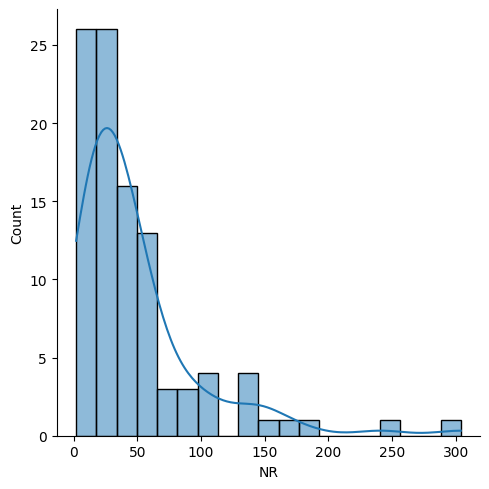

In [16]:
import seaborn as sns
sns.displot(df_query['NR'], kde=True)  # kde=True para adicionar uma estimativa de densidade do kernel
plt.show()

<Axes: xlabel='NR'>

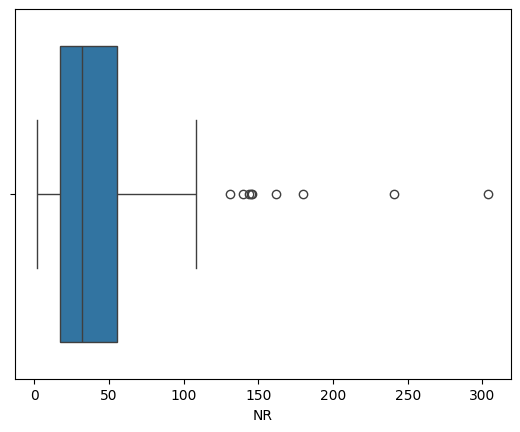

In [17]:
sns.boxplot(x=df_query['NR'])

In [18]:
import numpy as np
from scipy.stats import iqr
import pandas as pd

iqr(df_query['NR'])

38.5

### FAISS -> DF-IDF

### IndexFlatIP que utiliza a similaridade do cosseno


quantizer: É o índice usado como quantizador. No seu caso, é faiss.IndexFlatIP, que é um índice que usa a métrica do produto interno (similaridade cosseno). Os centroides são calculados usando esse índice.


nlist: É o número de células (clusters) para dividir o espaço de busca. Cada célula tem seu próprio conjunto de centroides. O nlist controla o trade-off entre eficiência e precisão. Um valor maior de nlist geralmente resulta em maior eficiência na busca, mas com uma pequena queda na precisão.


faiss.METRIC_INNER_PRODUCT: Indica que estamos usando a métrica do produto interno (similaridade cosseno) para a busca.

In [165]:
# FlatIP or IVFFlat
import faiss  

def apply_FAISS(document, d_ids, query, q_ids, type_index:str, K):
    
    initial_time = time.time()
    
    dim =  document.shape[1] # dimension
    nb = len(document) # database size
    nq = len(query) # nb of queries)
    nlist = len(query)
    document = np.asarray(document, dtype='float32')
    query = np.asarray(query, dtype='float32')

    if type_index == 'FlatIP':
        
        index = faiss.IndexFlatIP(dim)   
        index = faiss.IndexIDMap(index)

    if type_index == 'FlatIVFF':

        # normalizar as entradas
        document = document / np.linalg.norm( document, axis=1, keepdims=True)
        query = query / np.linalg.norm( query, axis=1, keepdims=True) 

        # Criar o índice IVFFlat para métrica do cosseno
        quantizer = faiss.IndexFlatIP(dim)  # Usamos o IndexFlatIP como quantizador
        index = faiss.IndexIVFFlat(quantizer, document.shape[1], nlist, faiss.METRIC_INNER_PRODUCT)

        # Treinar o índice
        index.train(document)
    
    index.add_with_ids(document, document_ids)
    
    # o I vai ser o id dos documentos recuperados
    D, I = index.search(query, K)     

    # Criar uma lista para armazenar as informações
    result = []
    # Iterar sobre os pontos de consulta e seus neighbors mais próximos
    for i, q_id in zip(range(len(I)), query_ids):
        
        neighbors = I[i]
        dist_neighbors = D[i]
        result.append({ 'id_query': q_id,
                        'retrieval': neighbors,
                        'dist': dist_neighbors})
    print(f"Execution Time = {time.time() - initial_time}")
    return pd.DataFrame(result)

In [166]:
# Vector TF-IDF
# FlatIP ou IVFFlat
print("FAISS FlatIP TF-IDF:")
resp_v = apply_FAISS(df_v_document, document_ids, df_v_query, query_ids, 'FlatIP', 10)
print("FAISS FlatIVFF TF-IDF:")
resp_v_IVFF = apply_FAISS(df_v_document, document_ids, df_v_query, query_ids, 'FlatIVFF', 10)
resp_v = pd.merge( resp_v, resp_v_IVFF, on='id_query', suffixes=('_IP', '_IVFF'))
resp_v.head()

FAISS FlatIP TF-IDF:
Execution Time = 0.176924467086792
FAISS FlatIVFF TF-IDF:
Execution Time = 0.5647807121276855


,id_query,retrieval_IP,dist_IP,retrieval_IVFF,dist_IVFF
0,1,"[484, 437, 499, 741, 498, 827, 957, 592, 533, ...","[0.2589415, 0.25389516, 0.23026434, 0.2285017,...","[437, 499, 498, 592, 754, 975, 151, 980, 501, ...","[0.25389516, 0.23026434, 0.22323118, 0.2062254..."
1,2,"[592, 498, 980, 754, 481, 499, 925, 114, 711, ...","[0.42752358, 0.20987636, 0.1886766, 0.17549495...","[592, 498, 980, 754, 499, 975, 151, 437, 501, ...","[0.42752358, 0.20987639, 0.1886766, 0.17549497..."
2,3,"[856, 633, 439, 959, 500, 1206, 23, 77, 805, 1...","[0.4266391, 0.39230436, 0.3165515, 0.29545963,...","[856, 633, 439, 500, 23, 805, 1196, 702, 553, ...","[0.4266391, 0.39230436, 0.3165515, 0.25877625,..."
3,4,"[715, 604, 357, 876, 725, 1030, 928, 662, 1039...","[0.40107936, 0.3433038, 0.29039, 0.2810194, 0....","[11, 322, 1185, 107, 386, 398, 187, 110, 1156,...","[0.18341568, 0.12244258, 0.10631809, 0.1054212..."
4,5,"[498, 754, 499, 711, 592, 265, 975, 151, 501, ...","[0.35646084, 0.33025038, 0.3027913, 0.29837427...","[498, 754, 499, 592, 975, 151, 501, 437, 980, ...","[0.35646087, 0.33025038, 0.3027913, 0.29595715..."


In [167]:
# Embeddings
# FlatIP ou IeFFlat
print("FAISS FlatIP Embeddings:")
resp_e = apply_FAISS(e_document, document_ids, e_query, query_ids, 'FlatIP', 10)
print("FAISS FlatIVFF Embeddings:")
resp_e_IVFFF = apply_FAISS(e_document, document_ids, e_query, query_ids, 'FlatIVFF', 10)
resp_e = pd.merge( resp_e, resp_e_IVFFF, on='id_query', suffixes=('_IP', '_IVFF'))
resp_e.head()

FAISS FlatIP Embeddings:
Execution Time = 0.0033979415893554688
FAISS FlatIVFF Embeddings:
Execution Time = 0.05205893516540527


,id_query,retrieval_IP,dist_IP,retrieval_IVFF,dist_IVFF
0,1,"[827, 461, 960, 533, 741, 454, 437, 975, 484, ...","[19.028828, 19.018747, 17.614992, 16.262873, 1...","[533, 437, 975, 499, 867, 498, 439, 500, 605, ...","[0.48338947, 0.42875463, 0.42085493, 0.365676,..."
1,2,"[975, 437, 805, 151, 265, 980, 498, 439, 461, ...","[16.072195, 15.253544, 14.646388, 14.53042, 14...","[975, 437, 592, 439, 500, 867, 498, 499, 605, ...","[0.5501344, 0.52322364, 0.4972262, 0.48528412,..."
2,3,"[439, 633, 805, 445, 1125, 950, 1175, 256, 374...","[17.994047, 16.580603, 16.448719, 16.26377, 15...","[445, 633, 950, 958, 246, 139, 520, 40, 137, 1...","[0.54492456, 0.52034605, 0.4842375, 0.46635973..."
3,4,"[604, 876, 669, 278, 374, 347, 439, 441, 924, ...","[19.566305, 18.690874, 16.48114, 16.212358, 16...","[604, 876, 970, 129, -1, -1, -1, -1, -1, -1]","[0.5452045, 0.49462777, 0.3407442, 0.26785085,..."
4,5,"[501, 867, 975, 498, 439, 437, 685, 1019, 875,...","[22.765892, 22.241232, 21.325352, 20.742886, 2...","[867, 975, 439, 437, 499, 498, 496, 533, 605, ...","[0.60940003, 0.56565666, 0.55383337, 0.5412614..."


## Join Results

In [168]:
dados_query = pd.merge(df_query_pp[['id_query','NR', 'RD']], resp_v, left_on='id_query', right_on='id_query')
dados_query = pd.merge(dados_query, resp_e, on='id_query', suffixes=('_v', '_e'))
dados_query.head(2)

,id_query,NR,RD,retrieval_IP_v,dist_IP_v,retrieval_IVFF_v,dist_IVFF_v,retrieval_IP_e,dist_IP_e,retrieval_IVFF_e,dist_IVFF_e
0,1,34,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ...","[484, 437, 499, 741, 498, 827, 957, 592, 533, ...","[0.2589415, 0.25389516, 0.23026434, 0.2285017,...","[437, 499, 498, 592, 754, 975, 151, 980, 501, ...","[0.25389516, 0.23026434, 0.22323118, 0.2062254...","[827, 461, 960, 533, 741, 454, 437, 975, 484, ...","[19.028828, 19.018747, 17.614992, 16.262873, 1...","[533, 437, 975, 499, 867, 498, 439, 500, 605, ...","[0.48338947, 0.42875463, 0.42085493, 0.365676,..."
1,2,7,"[169, 434, 454, 498, 499, 592, 875]","[592, 498, 980, 754, 481, 499, 925, 114, 711, ...","[0.42752358, 0.20987636, 0.1886766, 0.17549495...","[592, 498, 980, 754, 499, 975, 151, 437, 501, ...","[0.42752358, 0.20987639, 0.1886766, 0.17549497...","[975, 437, 805, 151, 265, 980, 498, 439, 461, ...","[16.072195, 15.253544, 14.646388, 14.53042, 14...","[975, 437, 592, 439, 500, 867, 498, 499, 605, ...","[0.5501344, 0.52322364, 0.4972262, 0.48528412,..."
2,3,43,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34...","[856, 633, 439, 959, 500, 1206, 23, 77, 805, 1...","[0.4266391, 0.39230436, 0.3165515, 0.29545963,...","[856, 633, 439, 500, 23, 805, 1196, 702, 553, ...","[0.4266391, 0.39230436, 0.3165515, 0.25877625,...","[439, 633, 805, 445, 1125, 950, 1175, 256, 374...","[17.994047, 16.580603, 16.448719, 16.26377, 15...","[445, 633, 950, 958, 246, 139, 520, 40, 137, 1...","[0.54492456, 0.52034605, 0.4842375, 0.46635973..."
3,4,9,"[503, 538, 539, 540, 553, 604, 669, 711, 876]","[715, 604, 357, 876, 725, 1030, 928, 662, 1039...","[0.40107936, 0.3433038, 0.29039, 0.2810194, 0....","[11, 322, 1185, 107, 386, 398, 187, 110, 1156,...","[0.18341568, 0.12244258, 0.10631809, 0.1054212...","[604, 876, 669, 278, 374, 347, 439, 441, 924, ...","[19.566305, 18.690874, 16.48114, 16.212358, 16...","[604, 876, 970, 129, -1, -1, -1, -1, -1, -1]","[0.5452045, 0.49462777, 0.3407442, 0.26785085,..."
4,5,131,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,...","[498, 754, 499, 711, 592, 265, 975, 151, 501, ...","[0.35646084, 0.33025038, 0.3027913, 0.29837427...","[498, 754, 499, 592, 975, 151, 501, 437, 980, ...","[0.35646087, 0.33025038, 0.3027913, 0.29595715...","[501, 867, 975, 498, 439, 437, 685, 1019, 875,...","[22.765892, 22.241232, 21.325352, 20.742886, 2...","[867, 975, 439, 437, 499, 498, 496, 533, 605, ...","[0.60940003, 0.56565666, 0.55383337, 0.5412614..."


# Evaluation

In [171]:
result_IP_v = dados_query.rename(columns={'NR':'qnt_doc_relevant', 'RD':'doc_relevant', 'retrieval_IP_v':'doc_retrieval'})
result_IP_v = result_IP_v[['id_query', 'qnt_doc_relevant', 'doc_relevant', 'doc_retrieval']]
result_IP_v.head()

,id_query,qnt_doc_relevant,doc_relevant,doc_retrieval
0,1,34,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ...","[484, 437, 499, 741, 498, 827, 957, 592, 533, ..."
1,2,7,"[169, 434, 454, 498, 499, 592, 875]","[592, 498, 980, 754, 481, 499, 925, 114, 711, ..."
2,3,43,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34...","[856, 633, 439, 959, 500, 1206, 23, 77, 805, 1..."
3,4,9,"[503, 538, 539, 540, 553, 604, 669, 711, 876]","[715, 604, 357, 876, 725, 1030, 928, 662, 1039..."
4,5,131,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,...","[498, 754, 499, 711, 592, 265, 975, 151, 501, ..."


In [178]:
result_IP_v.head(1)

,id_query,qnt_doc_relevant,doc_relevant,doc_retrieval
0,1,34,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ...","[484, 437, 499, 741, 498, 827, 957, 592, 533, ..."


In [182]:
def find_position(relevant, retrieval):

    for i, elemento in enumerate(retrieval):
        if elemento in relevant:
            return i  # Retorna a posição onde o elemento foi encontrado em l2

    return -1  # Retorna None se nenhum elemento de l2 estiver em l1

# Encontrar a posição
posicao = encontrar_posicao(l1, l2)
result_IP_v['first_position'] = result_IP_v.apply(lambda row: find_position(row['doc_relevant'], row['doc_retrieval']), axis=1)
result_IP_v

,id_query,qnt_doc_relevant,doc_relevant,doc_retrieval,first_position
0,1,34,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ...","[484, 437, 499, 741, 498, 827, 957, 592, 533, ...",5
1,2,7,"[169, 434, 454, 498, 499, 592, 875]","[592, 498, 980, 754, 481, 499, 925, 114, 711, ...",0
2,3,43,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34...","[856, 633, 439, 959, 500, 1206, 23, 77, 805, 1...",0
3,4,9,"[503, 538, 539, 540, 553, 604, 669, 711, 876]","[715, 604, 357, 876, 725, 1030, 928, 662, 1039...",1
4,5,131,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,...","[498, 754, 499, 711, 592, 265, 975, 151, 501, ...",0
...,...,...,...,...,...
95,96,12,"[9, 40, 43, 75, 454, 455, 520, 526, 527, 673, ...","[455, 454, 197, 871, 1166, 1087, 594, 514, 108...",0
96,97,11,"[52, 68, 135, 140, 190, 392, 416, 538, 539, 75...","[539, 1225, 751, 958, 757, 1185, 383, 140, 924...",0
97,98,15,"[145, 180, 270, 272, 362, 467, 595, 667, 728, ...","[791, 1150, 64, 145, 440, 559, 107, 699, 516, ...",3
98,99,5,"[268, 324, 449, 992, 1191]","[268, 449, 324, 566, 322, 364, 107, 55, 190, 988]",0


In [174]:
def calculate_precision_recall_complete(data):
    
    precision_recall_list = []

    for row in data.iterrows():

        id_query = row[1]['id_query']
        qnt_doc_relevantes = row[1]['qnt_doc_relevant']
        doc_relevantes = set(row[1]['doc_relevant'])
        doc_recuperados = set(row[1]['doc_retrieval'])

        # Calcular a Precisão (Precision)
        precision = len(doc_relevantes.intersection(doc_recuperados)) / len(doc_recuperados) if len(doc_recuperados) > 0 else 0
        # Calcular o Recall
        recall = len(doc_relevantes.intersection(doc_recuperados)) / qnt_doc_relevantes

        # Armazenar os resultados
        precision_recall_list.append({
            'id_query': id_query,
            'precision_general': precision,
            'recall_general': recall
        })

    return pd.DataFrame( precision_recall_list)

pr_complete_IP_v = calculate_precision_recall_complete(result_IP_v)
pr_complete_IP_v.head()

,id_query,precision_general,recall_general
0,1,0.2000,0.0588
1,2,0.3000,0.4286
2,3,0.5000,0.1163
3,4,0.2000,0.2222
4,5,0.9000,0.0687


In [137]:
def calculate_precision_recall_by_level(df:pd.DataFrame)->pd.DataFrame:

    result = []

    for _, row in df.iterrows():

        id_query = row['id_query']
        total_retrieval = row['doc_retrieval']
        
        # Itera de 10% até 100% em incrementos de 10%
        for percentage in range(10, 101, 10):

            qnt_elements = int(len(total_retrieval) * percentage / 100)
            doc_retrieval_it = total_retrieval[:qnt_elements]

            # Documentos relevantes na iteração atual
            doc_relevant_it = set(row['doc_relevant'][:qnt_elements])

            # Cálculo da interseção entre documentos recuperados e relevantes
            intersection = set(doc_retrieval_it).intersection(set(row['doc_relevant']))
            # Cálculo da precisão (precision) e recall
            precision = len(intersection) / len(doc_retrieval_it) if len(doc_retrieval_it) > 0 else 0
            recall = len(intersection) / len(doc_relevant_it) if len(doc_relevant_it) > 0 else 0

            result.append({
                'id_query': id_query,
                'percent_retrieval': percentage,
                'precision': f"{precision:.2f}",
                'recall': f"{recall:.2f}",
                'doc_retrieval': doc_retrieval_it
            })



    return pd.DataFrame(result)


In [175]:
# ver o que é o p@5 e o p@10 e calculá-los
pr_level_IP_v = calculate_precision_recall_by_level(result_IP_v)
pr_level_IP_v.head()


,id_query,percent_retrieval,precision,recall,doc_retrieval
0,1,10,0.00,0.00,[484]
1,1,20,0.00,0.00,"[484, 437]"
2,1,30,0.00,0.00,"[484, 437, 499]"
3,1,40,0.00,0.00,"[484, 437, 499, 741]"
4,1,50,0.00,0.00,"[484, 437, 499, 741, 498]"


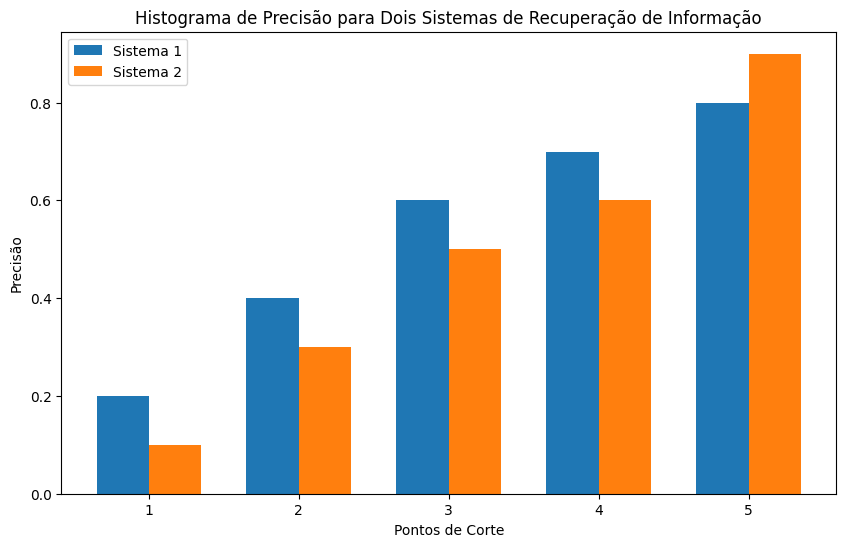

In [186]:
import matplotlib.pyplot as plt

# Dados de precisão para cada sistema em diferentes pontos de corte
pontos_de_corte = [1, 2, 3, 4, 5]
sistema1_precisao = [0.2, 0.4, 0.6, 0.7, 0.8]
sistema2_precisao = [0.1, 0.3, 0.5, 0.6, 0.9]

# Definindo a largura das barras
largura_barra = 0.35

# Coordenadas das barras para os sistemas
barra_sistema1 = [x - largura_barra/2 for x in pontos_de_corte]
barra_sistema2 = [x + largura_barra/2 for x in pontos_de_corte]

# Criando o histograma de precisão
plt.figure(figsize=(10, 6))
plt.bar(barra_sistema1, sistema1_precisao, largura_barra, label='Sistema 1')
plt.bar(barra_sistema2, sistema2_precisao, largura_barra, label='Sistema 2')

# Adicionando legendas e rótulos
plt.xlabel('Pontos de Corte')
plt.ylabel('Precisão')
plt.title('Histograma de Precisão para Dois Sistemas de Recuperação de Informação')
plt.xticks(pontos_de_corte)
plt.legend()

# Exibindo o gráfico
plt.show()


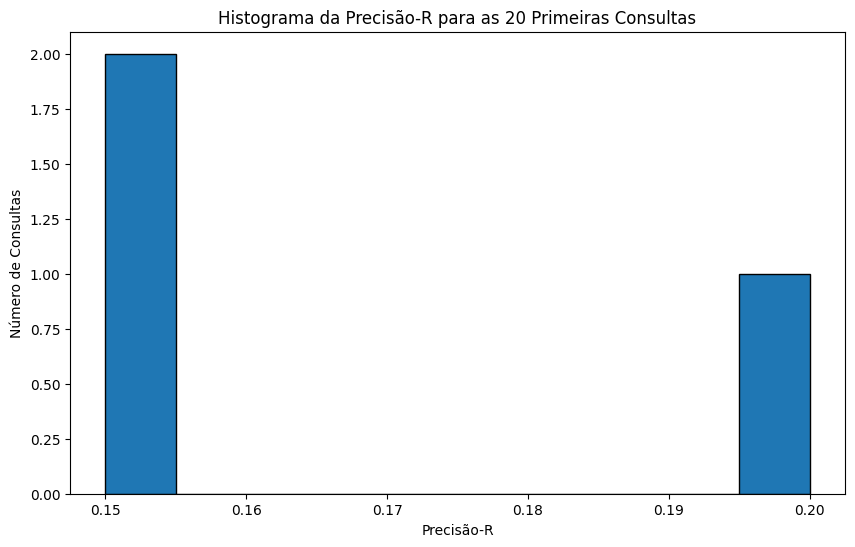

In [187]:
import matplotlib.pyplot as plt
import numpy as np

# Dados fictícios de relevância para os documentos (1 para relevante, 0 para não relevante)
# Cada linha representa uma consulta, e cada coluna representa um documento
dados_relevancia = np.array([
    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
    [1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
])

# Número de consultas
num_consultas = dados_relevancia.shape[0]

# Calcular precisão-R para cada consulta até os primeiros k documentos
k = 20  # número de documentos considerados
precisao_r_por_consulta = []

for i in range(num_consultas):
    relevantes_ate_k = dados_relevancia[i][:k]  # documentos relevantes até k
    precisao_r_k = np.sum(relevantes_ate_k) / k
    precisao_r_por_consulta.append(precisao_r_k)

# Criar histograma da precisão-R para as 20 primeiras consultas
plt.figure(figsize=(10, 6))
plt.hist(precisao_r_por_consulta, bins=10, edgecolor='black')
plt.xlabel('Precisão-R')
plt.ylabel('Número de Consultas')
plt.title('Histograma da Precisão-R para as 20 Primeiras Consultas')
plt.show()


Precisão (Precision): A proporção dos documentos recuperados que são relevantes.
Revocação (Recall): A proporção dos documentos relevantes que foram recuperados.
P@5 (Precision at 5): A precisão considerando apenas os primeiros 5 documentos recuperados.
P@10 (Precision at 10): A precisão considerando apenas os primeiros 10 documentos recuperados.
### Se é para recuperar o p@10, no mínimo tem que vir 10 documentos na pesquisa :)

## Histogram e MRR

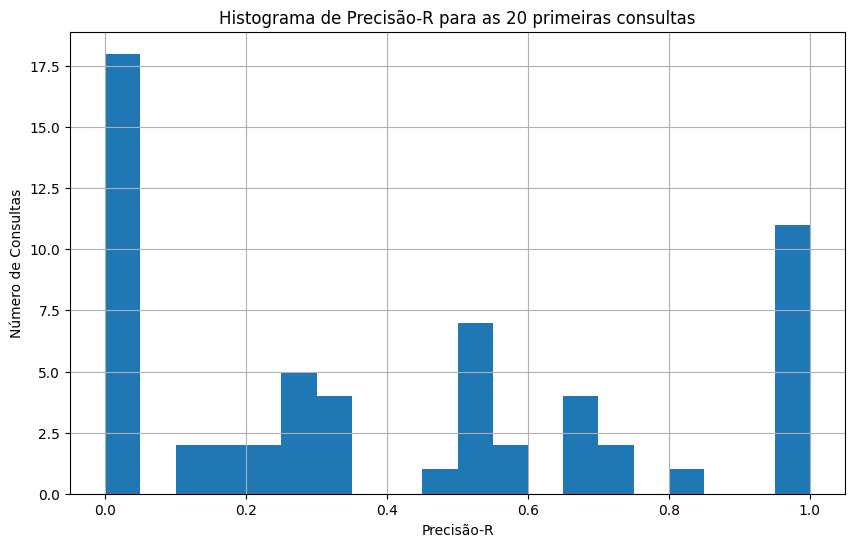

MRR(Q) considerando Sh = 5: 1.0


In [85]:
def plot_hist_and_mrr(metrics_df):
    # Calcular o rank para cada consulta
    metrics_df['rank'] = metrics_df.groupby('id_query').cumcount() + 1

    # Calcular o rank para cada consulta
    metrics_df['reciprocal_rank'] = 1 / (metrics_df['rank'])  # O inverso do rank é o reciprocal rank

    # Calcular MRR(Q) considerando Sh = 5
    Sh = 5
    mrr = metrics_df[metrics_df['rank'] <= Sh].groupby('id_query')['reciprocal_rank'].max().mean()

    # Traçar o histograma da precisão-R para as 20 primeiras consultas
    plt.figure(figsize=(10, 6))  # Movido para aqui
    plt.hist(metrics_df[metrics_df['rank'] <= 20]['precision'], bins=20)
    plt.xlabel('Precisão-R')
    plt.ylabel('Número de Consultas')
    plt.title('Histograma de Precisão-R para as 20 primeiras consultas')
    plt.grid(True)
    plt.show()

    print('MRR(Q) considerando Sh = 5:', mrr)
# Suponha que você tenha um DataFrame 'metrics_df'
plot_hist_and_mrr(metrics_df)